# First Experiment with HCC1806 cell line Smartseq Technology

Import libraries.

In [3]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             
import seaborn as sns  
import pandas as pd



Get the metadata

In [ ]:
mt_HCC = pd.read_csv("",delimiter="\t",engine='python',index_col=0)


In [ ]:
print("Dataframe dimensions:", np.shape(mt_HCC))
print("First column: ", mt_HCC.iloc[ : , 0])

In [ ]:
mt_HCC.head()

In [ ]:
mt_HCC.columns.tolist()

### Meaning of the metadata

Rows encode the information that we have on the columns for that sample.

Cell Line:
The biological cell line used in the experiment. Here we have HCC1806, a breast cancer cell line.

PCR Plate: 
The physical plate used to perform Polymerase Chain Reaction (PCR), which is a laboratory method used to amplify DNA sequences.

Pos:
Sample position or plate coordinate.

Condition:
The experimental condition applied:

Hypo: Hypoxia (low oxygen).

Norm: Normoxia (normal oxygen levels).

Hours:
The duration of the treatment in hourS, here, 72 hours.

Cell name:
Sample ID.

PreprocessingTag:
Indicates how the BAM file was processed prior to analysis. Here, all files are Aligned.sortedByCoord.out.bam, meaning the reads were aligned and sorted by genomic coordinates.

ProcessingComments:
Notes on the software/tools used:

STAR: The aligner used for mapping reads.

FeatureCounts: The tool used for quantifying gene expression from the BAM files.



## Unfiltered data

In [ ]:
unf_HCC= pd.read_csv("",delim_whitespace=True, index_col=0)
print("Dataframe dimensions:", np.shape(unf_HCC))
print("First column: ", unf_HCC.iloc[ : , 0])

In [ ]:
unf_HCC.head()

Rows are symbols to identify genes, columns are our samples with information encoded in their name. 

In [ ]:
list(unf_HCC.columns)

In [ ]:
gene_symbols = unf_HCC.index
print("Dataframe indexes: ", gene_symbols)

# Exploratory data analysis

In [ ]:
np.shape(unf_HCC)

(23396, 243)

In [ ]:
unf_HCC.dtypes

All data is numerical.

In [ ]:
X= unf_HCC.to_numpy()
X


In [ ]:
print(unf_HCC.isnull().sum())

There is no missing values.

In [ ]:
unf_HCC.describe()

In [ ]:
cnames = list(unf_HCC.columns)
cnames[1]
sns.boxplot(x=unf_HCC[cnames[1]])

In [ ]:
sns.violinplot(x=unf_HCC[cnames[1]])

In [ ]:
gene_stats = pd.DataFrame(index=unf_HCC.index)  
gene_stats['mean'] = unf_HCC.mean(axis=1)
gene_stats['std'] = unf_HCC.std(axis=1)
gene_stats['min'] = unf_HCC.min(axis=1)
gene_stats['max'] = unf_HCC.max(axis=1)
gene_stats['zero_fraction'] = (unf_HCC == 0).sum(axis=1) / unf_HCC.shape[1]


In [ ]:
gene_stats['mean'].hist(bins=50)
plt.title("Histogram of Mean Gene Expression")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.show()

In [ ]:
unf_HCC.boxplot(figsize=(12, 6), showfliers=False)
plt.title("Expression Distribution per Sample")
plt.xlabel("Sample")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Since our data is big, we will look at the most expressed genes.

In [ ]:
top_variable_genes = gene_stats['std'].sort_values(ascending=False).head(50).index
df_filtered = unf_HCC.loc[top_variable_genes]


In [ ]:
import matplotlib.pyplot as plt

df_filtered.T.boxplot(showfliers=False, figsize=(14, 6))
plt.title("Expression Distribution per Sample (Top 50 Genes)")
plt.ylabel("Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import numpy as np

top_50 = df_filtered.var(axis=1).sort_values(ascending=False).head(50).index
top_50_data = df_filtered.loc[top_50]

zscore_data = (top_50_data - top_50_data.mean(axis=1).values[:, None]) / top_50_data.std(axis=1).values[:, None]

plt.figure(figsize=(12, 10))
sns.heatmap(zscore_data, cmap='viridis', xticklabels=False)
plt.title("Heatmap: Top 50 Most Variable Genes")
plt.show()


In [ ]:
sample_stats = pd.DataFrame(index=unf_HCC.columns)  
sample_stats['mean'] = unf_HCC.mean(axis=0)
sample_stats['std'] = unf_HCC.std(axis=0)
sample_stats['min'] = unf_HCC.min(axis=0)
sample_stats['max'] = unf_HCC.max(axis=0)
sample_stats['zero_fraction'] = (unf_HCC == 0).sum(axis=0) / unf_HCC.shape[0]

In [ ]:
top_variable_samples = sample_stats['std'].sort_values(ascending=False).head(50).index
df_small = unf_HCC[top_variable_samples]


In [ ]:

np.shape(df_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
gene_stats['variance'] = unf_HCC.var(axis=1)

plt.scatter(gene_stats['mean'], gene_stats['variance'], alpha=0.5, s=10)
plt.title("Mean vs Variance of Gene Expression")
plt.xlabel("Mean Expression")
plt.ylabel("Variance")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


### Outliers and Sparsity

In [ ]:
Q1 = unf_HCC.quantile(0.25)
Q3 = unf_HCC.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
df_noOut = unf_HCC[~((unf_HCC < (Q1 - 1.5 * IQR)) |(unf_HCC > (Q3 + 1.5 * IQR))).any(axis=1)]
df_noOut.shape
df_noOut.head(5)

In [ ]:
sns.boxplot(x=df_noOut[cnames[1]])


In [ ]:
df_noOut_small = unf_HCC.iloc[:, :50]
np.shape(df_noOut_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df_noOut_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

Look at the sparsity percentege of the data.

In [ ]:
total_values = unf_HCC.size

zero_values = (unf_HCC == 0).sum().sum()

sparsity = zero_values / total_values
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 55.85%


### Distribution of the Data

In [ ]:
from scipy.stats import kurtosis, skew
colN = np.shape(unf_HCC)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unf_HCC[cnames[i]]
     df_skew_cells += [skew(v_df)]   
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - original df')

In [ ]:
df_kurt_cells = []
for i in range(colN) :     
     v_df = unf_HCC[cnames[i]]
     df_kurt_cells += [kurtosis(v_df)]   
df_kurt_cells
sns.histplot(df_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - original df')

### Data Transformation

In [ ]:
df1 = unf_HCC + 1
df1_log2 = df1.apply(np.log2)
# I'm selecting part of the data as the plots would otherwise take too long to generate
df1_log2_small = df1_log2.iloc[:, :50]
np.shape(df1_log2_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=df1_log2_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)

In [ ]:
df1_log2_skew_cells = []
for i in range(colN) :     
     v_df = df1_log2[cnames[i]]
     df1_log2_skew_cells += [skew(v_df)]   
df1_log2_skew_cells
sns.histplot(df1_log2_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - log2 df')

In [ ]:
df1_log2_kurt_cells = []
for i in range(colN) :     
     v_df = df1_log2[cnames[i]]
     df1_log2_kurt_cells += [kurtosis(v_df)] 
df1_log2_kurt_cells
sns.histplot(df1_log2_kurt_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - log2 df')

In [ ]:
unf_HCC = df1_log2

In [ ]:
df_small = unf_HCC.iloc[:, 10:30] 
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

Most values are concentrated near 0, suggesting lots of zero or low counts.

Distributions differ across cells, with some curves showing clear peaks while others are flat or skewed.

The red curve is extremely peaked at 0 — this suggests a highly sparse cell, with many genes not expressed at all.

Log-transformation reduces the influence of highly expressed genes and helps bring the distribution closer to normal.

We try another technique to see if we can get better graphs. 

In [ ]:
cpm = unf_HCC.div(unf_HCC.sum(axis=0), axis=1) * 1e6


In [ ]:
log_cpm = np.log2(cpm + 1)

In [ ]:
df_small = log_cpm.iloc[:, 10:30]  
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

It's much improved compared to the earlier one. Most cells now have similarly shaped distributions, indicating successful normalization.
Distributions are centered and compressed, as expected after log-transformation and CPM normalization.
However, there's one red spike near 0, much taller than the others — this suggests one cell has a disproportionately high number of zero or very low expression values.

In [ ]:

zero_counts_per_cell = (unf_HCC == 0).sum()

zero_log_counts = (log_cpm == 0).sum()

print(zero_log_counts.sort_values(ascending=False).head())


Let's further look at one of the samples in this list.

In [ ]:
cell_name = zero_log_counts.idxmax()
log_cpm[cell_name].plot(kind='hist', bins=50, title=f'Expression for {cell_name}')

We see that it has only zero counts. We can eliminate these samples in our data set.

## Duplicates

In [ ]:
duplicate_rows_df = unf_HCC[unf_HCC.duplicated(keep=False)]
print("number of duplicate rows: ", duplicate_rows_df.shape)
print("number of duplicate rows: ", duplicate_rows_df)

In [ ]:
print("names of duplicate rows: ",duplicate_rows_df.index)
duplicate_rows_df_t = duplicate_rows_df.T
duplicate_rows_df_t
c_dupl = duplicate_rows_df_t.corr()
c_dupl

In [ ]:
duplicate_rows_df_t.describe()

We group the duplicates.

In [ ]:
grouped = duplicate_rows_df.groupby(list(unf_HCC.columns))

for name, group in grouped:
    print("Duplicate group:\n", group.index.tolist())

We log the duplicates genes that we eliminated to a csv file.

In [ ]:

dup_groups = grouped.groups.values()
genes_to_drop = [genes[1:] for genes in dup_groups if len(genes) > 1]
flat_genes_to_drop = [gene for sublist in genes_to_drop for gene in sublist]

import pandas as pd
pd.Series(flat_genes_to_drop).to_csv("dropped_duplicate_genes.csv", index=False)


df_log_nodup = unf_HCC.drop(index=flat_genes_to_drop)


In [ ]:
unf_HCC = df_log_nodup

In [ ]:
unf_HCC.count()

## Filtered

In [ ]:
f_HCC = pd.read_csv("",delim_whitespace=True, index_col=0)

In [ ]:
f_HCC.shape

(19503, 227)

In [ ]:
fnames = list(f_HCC.columns)
fnames[1]
sns.boxplot(x=f_HCC[fnames[1]])

In [ ]:
col = np.shape(f_HCC)[1]
col
df_cells = []
for i in range(col) :     
     f_df = f_HCC[fnames[i]]
     df_cells += [skew(f_df)]   
df_cells
sns.histplot(df_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - filtered data')

In [ ]:
df_k_cells = []
for i in range(col) :     
     f_df = f_HCC[fnames[i]]
     df_k_cells += [kurtosis(f_df)] 
df_k_cells
sns.histplot(df_k_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - filtered data')

In [ ]:
f_small = f_HCC.iloc[:, 10:30]  
sns.displot(data=f_small,palette="Set3",kind="kde", bw_adjust=2)

## Normalized

In [ ]:
n_HCC = pd.read_csv("",delim_whitespace=True, index_col=0)

In [ ]:
n_HCC.shape

(3000, 182)

In [ ]:
n_HCC.head()

In [ ]:
nnames = list(n_HCC.columns)
nnames[1]
sns.boxplot(x=n_HCC[nnames[1]])

In [ ]:
ncol = np.shape(n_HCC)[1]
ncol
dn_cells = []
for i in range(ncol) :     
     n_df = n_HCC[nnames[i]]
     dn_cells += [skew(n_df)]   
dn_cells
sns.histplot(dn_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles - normalized data')

In [ ]:
df_n_cells = []
for i in range(ncol) :     
     n_df = n_HCC[nnames[i]]
     df_n_cells += [kurtosis(n_df)] 
df_n_cells
sns.histplot(df_n_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles - normalized data')

In [ ]:
n_small = n_HCC.iloc[:, 10:30]  
sns.displot(data=n_small,palette="Set3",kind="kde", bw_adjust=2)

# Correlations

In [ ]:
cell_corr = unf_HCC.corr() 

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cell_corr, cmap="coolwarm", center=0)
plt.title("Cell-Cell Correlation Matrix")
midpoint = (cell_corr.values.max() - cell_corr.values.min()) /2 + cell_corr.values.min()
print("Number of cells included: ", np.shape(cell_corr))
print("Average correlation of expression profiles between cells: ", midpoint)
print("Min. correlation of expression profiles between cells: ", cell_corr.values.min())

Most cells are strongly correlated, with correlation values mostly > 0.7
There are some white horizantel and vertical lines suggesting that the sample is low correlated with others.

In [ ]:
mean_corr = cell_corr.mean()
low_corr_cells = mean_corr[mean_corr < 0.7]  
print("Low correlation cells:", low_corr_cells.index.tolist())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cell in low_corr_cells.index[:5]:  
    plt.figure(figsize=(8,4))
    sns.histplot(unf_HCC[cell], bins=50, kde=True)
    plt.title(f"Gene Expression Distribution - {cell}")
    plt.xlabel("Expression Level")
    plt.ylabel("Gene Count")
    plt.show()


In [ ]:
top_genes = unf_HCC.var(axis=1).sort_values(ascending=False).head(50).index
gene_corr = unf_HCC.loc[top_genes].T.corr()


In [ ]:
sns.heatmap(gene_corr, cmap="coolwarm", center=0)
plt.title("Gene–Gene Correlation (Top 50 Most Variable Genes)")


In [ ]:
np.shape(cell_corr)
type(cell_corr)
cell_corr.head(3)
c_small=cell_corr.iloc[:,:3]
sns.histplot(c_small,bins=100)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')

# PCA and Clustering

In [ ]:
nf_train = pd.read_csv("",delim_whitespace=True, index_col=0)

In [106]:
nf_train.shape


(3000, 182)

In [ ]:
nf_train.head()

In [108]:
nf_train=nf_train.T

In [109]:
nf_train.shape

(182, 3000)

We will first try to choose the components of PCA by the ratio of the variance we want to preserve.

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(nf_train)
pca.n_components_, pca.explained_variance_ratio_.sum()

(34, 0.9508404630941673)

In [111]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained_variance_ratio)

cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance:", cumulative_variance)


Explained variance ratio by component: [0.29018923 0.18101256 0.12288734 0.07970126 0.04956884 0.03640102
 0.02737402 0.02113149 0.01743474 0.01317286 0.01208516 0.0111941
 0.00880007 0.00783661 0.00748447 0.00693555 0.00579659 0.00509238
 0.00467221 0.00422117 0.00399608 0.00383594 0.00365575 0.00342266
 0.00304432 0.00285331 0.00257095 0.00235782 0.0022066  0.00215775
 0.00209672 0.00204413 0.00186566 0.00174111]
Cumulative explained variance: [0.29018923 0.4712018  0.59408913 0.67379039 0.72335923 0.75976025
 0.78713427 0.80826577 0.82570051 0.83887337 0.85095853 0.86215263
 0.8709527  0.87878931 0.88627378 0.89320933 0.89900592 0.9040983
 0.90877051 0.91299168 0.91698776 0.92082369 0.92447944 0.9279021
 0.93094642 0.93379973 0.93637068 0.93872849 0.94093509 0.94309284
 0.94518956 0.94723369 0.94909935 0.95084046]


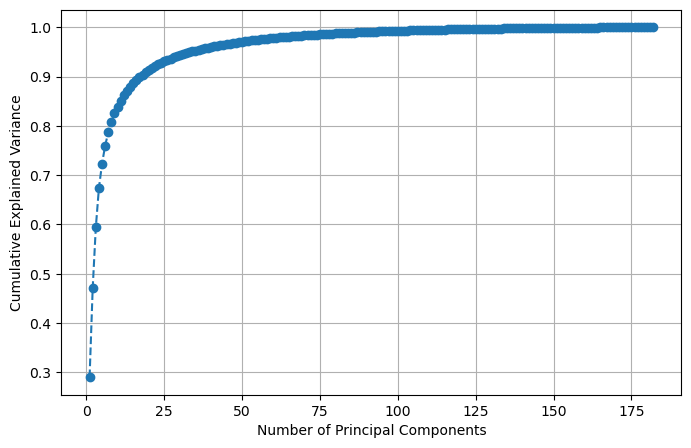

In [112]:
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
pca.fit(nf_train)  

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


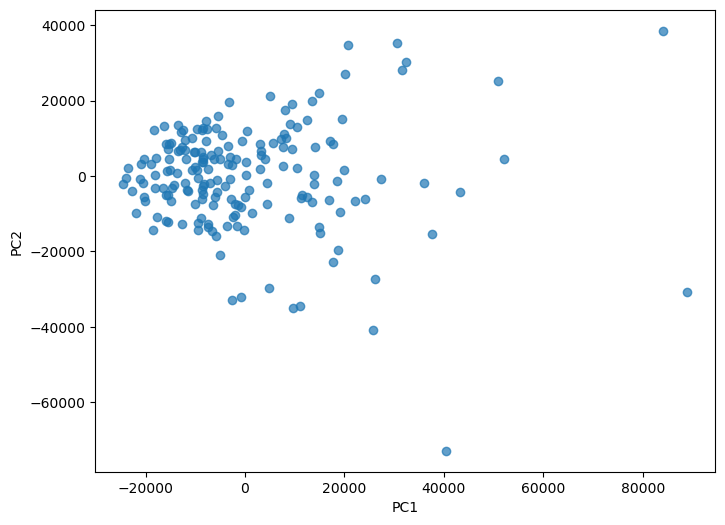

In [113]:
pca = PCA(n_components=34)
pca_result = pca.fit_transform(nf_train)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
import pandas as pd

loading_scores = pd.Series(pca.components_[0], index=nf_train.columns)
top_genes_pc1 = loading_scores.abs().sort_values(ascending=False).head(10)

print("Top contributing genes to PC1:")
print(top_genes_pc1)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_gene_names = top_genes_pc1.index.tolist()
plt.figure(figsize=(12, 6))
sns.boxplot(data=nf_train[top_gene_names])
plt.title("Expression of Top Contributing Genes to PC1")
plt.xticks(rotation=45)
plt.ylabel("Expression Level")
plt.show()


These genes are the top contributors to the first principal component of our PCA analysis. With 0.707134, FTL has high contribution. After some research, we found that the FTL gene encodes ferritin light chain, which is a subunit of ferritin, the major iron storage protein in cells.

k =  2 → silhouette = 0.263
k =  3 → silhouette = 0.162
k =  4 → silhouette = 0.172
k =  5 → silhouette = 0.182
k =  6 → silhouette = 0.119
k =  7 → silhouette = 0.123
k =  8 → silhouette = 0.184
k =  9 → silhouette = 0.158
k = 10 → silhouette = 0.133


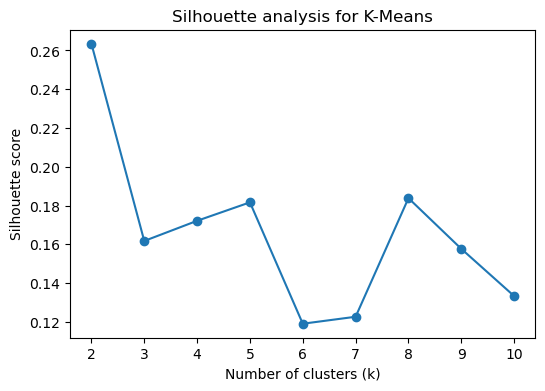

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_pca = pca_result

ks = np.arange(2, 11)         
sil_scores = []                

for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    labels = km.labels_
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)
    print(f"k = {k:2d} → silhouette = {sil:.3f}")


plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.xticks(ks)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis for K-Means")
plt.show()

Silhouette Score shows that the best number we can part the data is 2.

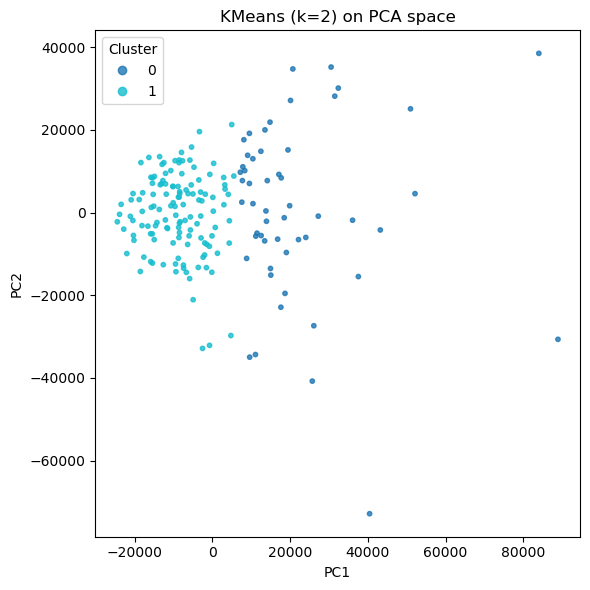

In [124]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_clusters = 2 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result)

plt.figure(figsize=(6,6))
scatter = plt.scatter(
    pca_result[:,0], pca_result[:,1],
    c=clusters, cmap='tab10', s=10, alpha=0.8
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans (k={n_clusters}) on PCA space")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [125]:
labels = kmeans.labels_
labels

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [126]:
nf_train['cluster'] = labels


In [ ]:
nf_train.head()

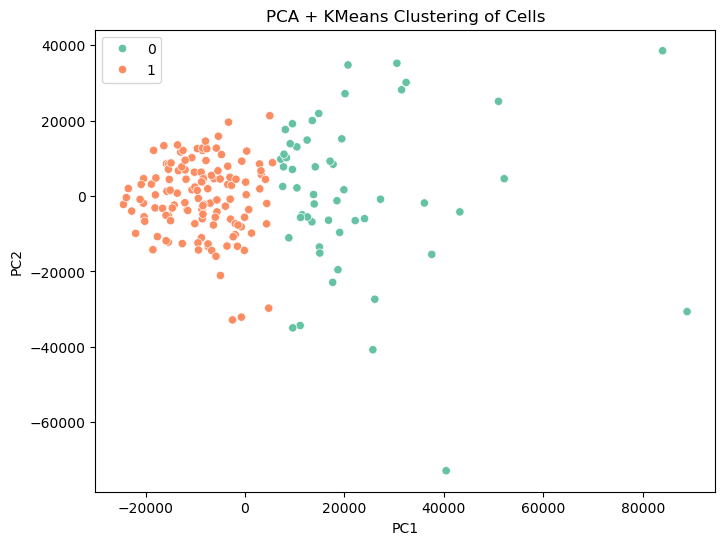

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set2')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA + KMeans Clustering of Cells")
plt.show()


In [ ]:
cell_names = nf_train[nf_train['cluster'] == 0].index.tolist()
cell_names

# Supervised learning

In [ ]:
nf_test =pd.read_csv("",delim_whitespace=True, index_col=0)

In [131]:
nf_test.shape

(3000, 45)

In [ ]:
nf_test.head()

In [ ]:
nf_train.head()

In [134]:
sample_names_train =nf_train.index

label_train=np.array([1 if "Hypoxia" in name else 0 for name in sample_names_train])
print(pd.Series(label_train, index=sample_names_train).value_counts())

1    97
0    85
Name: count, dtype: int64


In [135]:
nf_train.drop("cluster", axis=1, inplace=True)

Let's see if we have cells with too many zeros inorder to further reduce the data set.

In [136]:
cell_threshold = 0.1 

non_zero_fraction_genes = (nf_train != 0).sum(axis=1) / nf_train.shape[1]

df_filtered_genes = nf_train[non_zero_fraction_genes >= cell_threshold]

In [137]:
df_filtered_genes.shape

(182, 3000)

In [138]:
from sklearn.decomposition import PCA

pca = PCA(n_components=34)
df_pca = pca.fit_transform(nf_train)


In [139]:
def calculate_sparsity(data):
    total_values = data.size
    zero_values = (data == 0).sum().sum()
    return zero_values / total_values

print("Original sparsity:", calculate_sparsity(nf_train))
print("Filtered sparsity:", calculate_sparsity(df_pca))

Original sparsity: 0.7065347985347985
Filtered sparsity: 0.0


In [ ]:
nf_train.head()

### Model Selection

We will try different classifiers to find the most suitable one. Since our data is simple binary labeling, we can suspect that Logistic Regression will give a good score.

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}


In [142]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=34)),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, nf_train, label_train, cv=5)
    results[name] = scores.mean()
    print(f"{name}: CV accuracy = {scores.mean():.4f}")
    print(f"{name}: Training accuracy = {pipe.fit(nf_train, label_train).score(nf_train, label_train):.4f}")
    



Logistic Regression: CV accuracy = 0.9560
Logistic Regression: Training accuracy = 1.0000
Random Forest: CV accuracy = 0.9176
Random Forest: Training accuracy = 1.0000
SVM: CV accuracy = 0.9779
SVM: Training accuracy = 1.0000
Naive Bayes: CV accuracy = 0.5443
Naive Bayes: Training accuracy = 0.6538
KNN: CV accuracy = 0.9228
KNN: Training accuracy = 0.9615
Decision Tree: CV accuracy = 0.8622
Decision Tree: Training accuracy = 1.0000


In [143]:
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for name, score in sorted_results:
    print(f"{name:<20}  CV Accuracy: {score:.4f}")


SVM                   CV Accuracy: 0.9779
Logistic Regression   CV Accuracy: 0.9560
KNN                   CV Accuracy: 0.9228
Random Forest         CV Accuracy: 0.9176
Decision Tree         CV Accuracy: 0.8622
Naive Bayes           CV Accuracy: 0.5443


SVM and Logistic Regression models give better accuracy scores than others, however they also indicate over-fitting. Now we will perform randomized search to tune best-performing models in order to solve this problem. 

First, we perform Logistic regression with PCA component we found according to variance preservation.

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

pipe_all = Pipeline([
    ("scale",  StandardScaler()),        
    ("pca",    PCA(n_components=34)),      
    ("clf",    LogisticRegression(
                   max_iter=1000,
                   solver="liblinear"))
])

print("CV accuracy:", cross_val_score(pipe_all, nf_train, label_train, cv=5).mean())
pipe_all.fit(nf_train, label_train)
print("Training accuracy:", pipe_all.score(nf_train, label_train))

CV accuracy: 0.956006006006006
Training accuracy: 1.0


We will use RandomizedSearchCV to find the best hyperparameters for the Logistic Regression model.

In [145]:
pipe = Pipeline([
    ("scale",  StandardScaler()),        
    ("pca",    PCA(n_components=34)),      
    ("clf",    LogisticRegression(
                   max_iter=1000,
                   solver="liblinear"))
                
])
param_distributions = {
    "clf__C": loguniform(1e-3, 1e3)
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    random_state=42,
    verbose=1
)

search.fit(nf_train, label_train)

print("Best CV accuracy:", search.best_score_)
print ("Training accuracy:", search.score(nf_train, label_train))
print("Best parameters:", search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.9782282282282282
Training accuracy: 1.0
Best parameters: {'clf__C': 0.008632008168602538}


However, since the optimal number of principal components can vary depending on the algorithm used, we will determine the most suitable components specifically for the Logistic Regression model.

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import numpy as np

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA()),
    ("clf", LogisticRegression(max_iter=1000, solver='liblinear'))
])

param_distributions = {
    "pca__n_components": np.arange(10, 150),
    "clf__C": loguniform(1e-3, 1e3)
}

search_lr = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    random_state=42,
    verbose=1
)

search_lr.fit(nf_train, label_train)

print("Best CV accuracy:", search_lr.best_score_)
print ("Training accuracy:", search_lr.score(nf_train, label_train))
print("Best parameters:", search_lr.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.978078078078078
Training accuracy: 1.0
Best parameters: {'clf__C': 4.0428727350273315, 'pca__n_components': 140}


It is possible that even with regularization, our model is overfitting the data.

We will do the same process for SVM.

In [149]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import numpy as np
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA()),
    ("clf", SVC())
])

param_distributions = {
    "pca__n_components": np.arange(10, 150),  
    "clf__C": loguniform(1e-3, 1e3),         
         
}

search_svm = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    random_state=42,
    verbose=1
)

search_svm.fit(nf_train, label_train)

print("Best CV accuracy:", search_svm.best_score_)
print("Training accuracy:", search_svm.score(nf_train, label_train))
print("Best parameters:", search_svm.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV accuracy: 0.9782282282282282
Training accuracy: 1.0
Best parameters: {'clf__C': 5.068612120448909, 'pca__n_components': 67}


SVM gave better CV accuracy.

## Prediction

Our model with SVM

In [150]:
model_svm = search_svm.best_estimator_
print("Best model:", model_svm)

Best model: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=67)),
                ('clf', SVC(C=5.068612120448909))])


Our model with Logistic regression. 

In [151]:
model_lr = search_lr.best_estimator_
print("Best model:", model_lr)

Best model: Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=140)),
                ('clf',
                 LogisticRegression(C=4.0428727350273315, max_iter=1000,
                                    solver='liblinear'))])


In [156]:
label_predict_svm= model_svm.predict(nf_test.T)
print("Predicted labels:", label_predict_svm[:10])
print("Predicted labels shape:", label_predict_svm.shape)

with open("HCC1806_SmarSeq_predictions_svm.txt", "w") as f:
    for label in label_predict_svm:
        f.write(f"{label}\n")


Predicted labels: [0 0 1 1 1 1 1 0 0 0]
Predicted labels shape: (45,)


In [153]:
label_predict_lr = model_lr.predict(nf_test.T)
print("Predicted labels:", label_predict_lr[:10])
print("Predicted labels shape:", label_predict_lr.shape)

with open("HCC1806_S_predictions_lr.txt", "w") as f:
    for label in label_predict_lr:
        f.write(f"{label}\n")


Predicted labels: [0 0 1 1 1 1 1 0 0 0]
Predicted labels shape: (45,)


In [154]:
mask = label_predict_svm != label_predict_lr
print("Number of mismatches:", mask.sum())
mismatched_cells = nf_test.columns[mask]
print("Mismatched cells:", mismatched_cells.tolist())


Number of mismatches: 2
Mismatched cells: ['28', '35']
